## Homework 11

In [1]:
# import Glop package
from ortools.linear_solver import pywraplp as glp
import lptools as lpt
import matplotlib.pyplot as plt

In [2]:
#Create LP model object
mymodel = glp.Solver('Spencer Enterprises', glp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

In [3]:
inf = mymodel.infinity()

            # name: (type 'c'=continuous or 'i'=integer, lower bound, upper bound, objective coefficient)
variables = {'LWE ': ('i' ,0 ,1 ,4000 ),         # Limited Warehouse Expansion
             'EWE ': ('i' , 0, 1, 6000),           # Extensive Warehouse Expansion
             'TMNP': ('i' , 0,1 , 10500),           # Test Market New Product
             'AC': ('i' , 0, 1, 4000),             # Advertising Campaign
             'BR': ('i' , 0, 1, 8000),             # Basic Research
             'PNE': ('i' , 0, 1, 3000)}            # Purchase New Equipment
             

            # name: (lower bound, upper bound, coefficient list)
constraints = {'Y1 ': ( -inf,10500 , [3000 ,2500 ,6000,2000, 5000, 1000 ]),
               'Y2 ': (-inf ,7000 , [ 1000,3500 ,4000,1500, 1000, 500 ]),
               'Y3 ': (-inf ,8750 , [4000 ,3500 ,5000,1800, 4000, 900 ])}
               
mymodel.Objective().SetMaximization()

In [4]:
for v in variables:
    (t,lb,ub,c) = variables[v]
    if t == 'c':
        var = mymodel.NumVar(lb,ub,v)
    elif t == 'i':
        var = mymodel.IntVar(lb,ub,v)
    else:
        print('Invalid variable type =', t)
    mymodel.Objective().SetCoefficient(var,c)

In [5]:
for c in constraints:
    (lb,ub,coeff_lst) = constraints[c]
    constr = mymodel.Constraint(lb,ub,c)
    for (v,coeff) in zip(mymodel.variables(),coeff_lst):
        constr.SetCoefficient(v,coeff)

In [6]:
lpt.print_model(mymodel)

Variables:
LWE , EWE , TMNP, AC, BR, PNE 

maximize: 4000.0*LWE  + 6000.0*EWE  + 10500.0*TMNP + 4000.0*AC + 8000.0*BR + 3000.0*PNE 

Subject To:
Y1 : 3000.0*LWE  + 2500.0*EWE  + 6000.0*TMNP + 2000.0*AC + 5000.0*BR + 1000.0*PNE <= 10500.0
Y2 : 1000.0*LWE  + 3500.0*EWE  + 4000.0*TMNP + 1500.0*AC + 1000.0*BR + 500.0*PNE <= 7000.0
Y3 : 4000.0*LWE  + 3500.0*EWE  + 5000.0*TMNP + 1800.0*AC + 4000.0*BR + 900.0*PNE <= 8750.0

Bounds:
0.0 <= LWE  <= 1.0
0.0 <= EWE  <= 1.0
0.0 <= TMNP <= 1.0
0.0 <= AC <= 1.0
0.0 <= BR <= 1.0
0.0 <= PNE <= 1.0


In [7]:
#solve model and display results
status = mymodel.Solve()
print('Solution Status =',status)
print('Optimal Value = %.2f' % mymodel.Objective().Value())
for v in mymodel.variables():
    print('%s = %.2f' % (v.name(),v.solution_value()))

Solution Status = 0
Optimal Value = 17500.00
LWE  = 0.00
EWE  = 0.00
TMNP = 1.00
AC = 1.00
BR = 0.00
PNE = 1.00


In [8]:
# display variable information
print('Variable    LB   Value    UB')
for v in mymodel.variables():
    print('%8s  %5.1f  %5.1f  %5.1f' % (v.name(),v.lb(),v.solution_value(),v.ub()))


Variable    LB   Value    UB
    LWE     0.0    0.0    1.0
    EWE     0.0    0.0    1.0
    TMNP    0.0    1.0    1.0
      AC    0.0    1.0    1.0
      BR    0.0    0.0    1.0
     PNE    0.0    1.0    1.0


In [9]:
#display constraint information
print('Constraint    LB    Value  UB')
for (c,lhs) in zip(mymodel.constraints(),mymodel.ComputeConstraintActivities()):
    print('%10s  %5.1f  %5.1f  %5.1f' % (c.name(),c.lb(),lhs,c.ub()))

Constraint    LB    Value  UB
       Y1    -inf  9000.0  10500.0
       Y2    -inf  6000.0  7000.0
       Y3    -inf  7700.0  8750.0


In [10]:
# The optimal Soultion is 17,000 and Spencer Enterpirses chooses Extensive Warehouse Expansion, Basic Research, and Purchase New Equipment instead.

   
  ## Problem 2

In [11]:
# import Glop package
from ortools.linear_solver import pywraplp as glp
import lptools as lpt

In [12]:
# Create MILP model object
mymodel = glp.Solver('Scott Office Products', glp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

In [13]:
inf = mymodel.infinity()

         # name: supply capacity (thousand tons), fixed cost (thousand $), unit shipping cost ($) to each RDC
source = {'Cle': (30,320 , [ 2, 6, 20]),    # Clebeland
          'Nsh': (15,175 , [ 3, 4, 9]),    # Nashville
          'Stl': (30,300 , [ 5, 9, 7]),    # St. Louis
          'Mil':  (25,0 , [5, 10, 8])}   # Milwaukee
          

        # name: demand quantity required (thousand tons)
demand = {'Scr':20 , 'Atl': 10, 'Ren':25 }    # Scranton, Atlanta, Reno

mymodel.Objective().SetMinimization()    # minimize total plant and transportation cost

In [14]:
# create binary Plant selection variables and a dictionary to access them
select = dict()
for s in source:
    select[s] = mymodel.IntVar(0,1,s) 
    (b,f, coeff_lst) = source[s]
    mymodel.Objective().SetCoefficient(select[s], f )

In [15]:
# create shipment variables from Plants to RDCs and a dictionary to access them
ship = dict()
for s in source:
    ship[s] = dict()
    (b, f, coeff_lst) = source[s]
    for (d,c) in zip(demand,coeff_lst):
        ship[s][d] = mymodel.NumVar(0 ,inf, s + '.' + d)
        mymodel.Objective().SetCoefficient(ship[s][d] ,c )

In [16]:
# create source/supply constraints
for s in source:
    (b, f, coeff_lst) = source[s]
    constr = mymodel.Constraint(-inf ,0 ,s )
    constr.SetCoefficient(select[s] ,-b )
    for d in demand:
        constr.SetCoefficient(ship[s][d] , 1)

In [17]:
# create demand constraints
for d in demand:
    lb = ub = demand[d]
    constr = mymodel.Constraint(lb ,ub ,d )
    for s in source:
        constr.SetCoefficient( ship[s][d],1 )

In [18]:
lpt.print_model(mymodel)

Variables:
Cle, Nsh, Stl, Mil, Cle.Scr, Cle.Atl, Cle.Ren, Nsh.Scr, Nsh.Atl, Nsh.Ren, Stl.Scr, Stl.Atl, Stl.Ren, Mil.Scr, Mil.Atl, Mil.Ren 

minimize: 320.0*Cle + 175.0*Nsh + 300.0*Stl + 2.0*Cle.Scr + 6.0*Cle.Atl + 20.0*Cle.Ren + 3.0*Nsh.Scr + 4.0*Nsh.Atl + 9.0*Nsh.Ren + 5.0*Stl.Scr + 9.0*Stl.Atl + 7.0*Stl.Ren + 5.0*Mil.Scr + 10.0*Mil.Atl + 8.0*Mil.Ren 

Subject To:
Cle: - 30.0*Cle + 1.0*Cle.Scr + 1.0*Cle.Atl + 1.0*Cle.Ren <= 0.0
Nsh: - 15.0*Nsh + 1.0*Nsh.Scr + 1.0*Nsh.Atl + 1.0*Nsh.Ren <= 0.0
Stl: - 30.0*Stl + 1.0*Stl.Scr + 1.0*Stl.Atl + 1.0*Stl.Ren <= 0.0
Mil: - 25.0*Mil + 1.0*Mil.Scr + 1.0*Mil.Atl + 1.0*Mil.Ren <= 0.0
Scr: 1.0*Cle.Scr + 1.0*Nsh.Scr + 1.0*Stl.Scr + 1.0*Mil.Scr = 20.0
Atl: 1.0*Cle.Atl + 1.0*Nsh.Atl + 1.0*Stl.Atl + 1.0*Mil.Atl = 10.0
Ren: 1.0*Cle.Ren + 1.0*Nsh.Ren + 1.0*Stl.Ren + 1.0*Mil.Ren = 25.0

Bounds:
0.0 <= Cle <= 1.0
0.0 <= Nsh <= 1.0
0.0 <= Stl <= 1.0
0.0 <= Mil <= 1.0
Cle.Scr >= 0.0
Cle.Atl >= 0.0
Cle.Ren >= 0.0
Nsh.Scr >= 0.0
Nsh.Atl >= 0.0
Nsh.Ren >= 0.0
Stl

In [19]:
#solve model and display results
status = mymodel.Solve()
print('Solution Status =',status)
print('Optimal Value = %.2f thousand' % mymodel.Objective().Value())
for v in mymodel.variables():
    if v.solution_value() != 0:
        print('%7s = %5.2f' % (v.name(),v.solution_value()))

Solution Status = 0
Optimal Value = 620.00 thousand
    Cle =  1.00
    Mil =  1.00
Cle.Scr = 20.00
Cle.Atl = 10.00
Mil.Ren = 25.00


In [20]:
# display all variable information
print('Variable    LB   Value    UB')
for v in mymodel.variables():
    print('%8s  %5.1f  %5.1f  %5.1f' % (v.name(),v.lb(),v.solution_value(),v.ub()))

Variable    LB   Value    UB
     Cle    0.0    1.0    1.0
     Nsh    0.0    0.0    1.0
     Stl    0.0    0.0    1.0
     Mil    0.0    1.0    1.0
 Cle.Scr    0.0   20.0    inf
 Cle.Atl    0.0   10.0    inf
 Cle.Ren    0.0    0.0    inf
 Nsh.Scr    0.0    0.0    inf
 Nsh.Atl    0.0    0.0    inf
 Nsh.Ren    0.0    0.0    inf
 Stl.Scr    0.0    0.0    inf
 Stl.Atl    0.0    0.0    inf
 Stl.Ren    0.0    0.0    inf
 Mil.Scr    0.0    0.0    inf
 Mil.Atl    0.0    0.0    inf
 Mil.Ren    0.0   25.0    inf


In [21]:
#display constraint information
print('Constraint    LB    Value  UB')
for (c,lhs) in zip(mymodel.constraints(),mymodel.ComputeConstraintActivities()):
    print('%10s  %5.1f  %5.1f  %5.1f' % (c.name(),c.lb(),lhs,c.ub()))

Constraint    LB    Value  UB
       Cle   -inf    0.0    0.0
       Nsh   -inf    0.0    0.0
       Stl   -inf    0.0    0.0
       Mil   -inf    0.0    0.0
       Scr   20.0   20.0   20.0
       Atl   10.0   10.0   10.0
       Ren   25.0   25.0   25.0


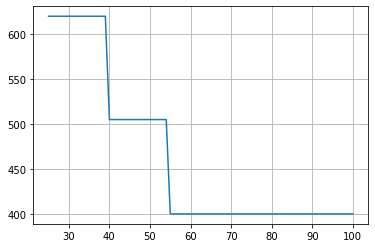

In [22]:
# optimization parameter analysis: Milwuakee capacity (25 - 100)

param_lst = list(range(25 ,101 ))
optval_lst = list()
for b in param_lst:
    mymodel.constraints()[3].SetCoefficient(select['Mil'],-b )    # constraint index 3 is Milwuakee supply constraint
    mymodel.Solve()
    optval_lst.append(mymodel.Objective().Value())
    
mymodel.constraints()[3].SetCoefficient(select['Mil'] , -25)

plt.grid()
plt.plot(param_lst,optval_lst)

In [23]:
# At every step, you get enough capacity at Milwaukee to change distrubution centers